### Declaração de Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas_datareader as pdr
import fix_yahoo_finance as fyf
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pickle
#% matplotlib inline

### Obter top 5 do índice Bovespa:

Funções usadas para baixar os índices da Bovespa

In [ ]:
def get_html_page(url):
    page = urlopen(url)
    soup_page = BeautifulSoup(page, 'html.parser')
    return soup_page

def get_indicator_assets(html_soup_page):
    rgRows = html_soup_page.findAll('tr', attrs={'class':'rgRow'})
    rgAltRows = html_soup_page.findAll('tr', attrs={'class':'rgAltRow'})
    rgRows = rgRows+rgAltRows

    indicator_assets = []
    for rgRow in rgRows:
        rawData = rgRow.findAll('span')
        codigo = rawData[0].contents[0]
        acao   = rawData[1].contents[0]
        tipo   = rawData[2].contents[0]
        qtd_teorica = rawData[3].contents[0]
        participacao = rawData[4].contents[0]
        asset_data = [codigo, acao, tipo, qtd_teorica, participacao]
        indicator_assets.append(asset_data)
    return indicator_assets

Download das ações do indice IBOV

In [ ]:
# IBOV
url = 'http://bvmf.bmfbovespa.com.br/indices/ResumoCarteiraTeorica.aspx?Indice=IBOV&idioma=pt-br'
# IBVX -> 'http://bvmf.bmfbovespa.com.br/indices/ResumoCarteiraTeorica.aspx?Indice=IVBX&amp;idioma=pt-br'
soup_page = get_html_page(url)
IVBX2_index = get_indicator_assets(soup_page)
if (len(IVBX2_index) == 0):
    print('ERROR READING - TRY AGAIN')
    
# display(IVBX2_index)

In [ ]:
assets_codes = np.array(IVBX2_index)[:,0]
assets_codes_SA = [x + '.SA' for x in assets_codes]
print(assets_codes_SA)

### Saving data to pickle file:

In [ ]:
### Get data from yahoo finance
stock_data = {}
volume_data = {}
for asset_code in assets_codes_SA:
    print('Downloading: ', asset_code)
    stock_data[asset_code] = pdr.get_data_yahoo(asset_code, start='2015-01-01')
    volume_data[asset_code] = stock_data[asset_code]['Volume'].sum()

# Save stocks to file
with open('stock_data.pkl', 'wb') as f:
    pickle.dump([stock_data, volume_data], f)

### Loading data from pickle file:

In [2]:
# Load stocks from file
with open('stock_data.pkl', 'rb') as f:
    stock_data, volume_data = pickle.load(f)

### Obter os top 5 - liquidez :

In [3]:
top_5_liquid = sorted(volume_data.items(), key = lambda x:x[1])[-5:]
top_5_keys = [asset[0] for asset in top_5_liquid]
print(top_5_keys)

['ITUB4.SA', 'GOAU4.SA', 'USIM5.SA', 'ITSA4.SA', 'PETR4.SA']


------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------

### Definir estratégia

In [4]:
def short_and_long_mavg_from_price_df(price_df, short_window, long_window):
    price = price_df.copy()
    
    # MOVING AVERAGE
    fast_ma = price.rolling(short_window).mean()
    slow_ma = price.rolling(long_window).mean()
    price['short_mavg'] = fast_ma
    price['long_mavg'] = slow_ma
    
    # SIGNAL
    price['positions'] = 0.0
    price['positions'][short_window:] = np.where(price['short_mavg'][short_window:] \
                                            > price['long_mavg'][short_window:], 1.0, 0.0)  
    # BUY / SELL
    price['positions_diff'] = price['positions'].diff().copy()
    
    return price



stock_data_adj_close = {}
for asset in top_5_keys:
    price = stock_data[asset][['Adj Close']]
    stock_data_adj_close[asset] = short_and_long_mavg_from_price_df(price, 8, 20)

### Plot das operações - 1

In [5]:
def plot_asset_mavg_position(asset):
  
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

    ax[0].plot(asset['Adj Close'], label='Close',color='r')
    ax[0].plot(asset['short_mavg'], label='short_mavg')
    ax[0].plot(asset['long_mavg'], label='long_mavg')
    ax[0].set_ylabel("Preço [R$]")
    ax[0].set_xlabel("Data")
    ax[0].set_title("Médias")
    ax[0].legend(loc='upper left')

    ax[1].plot(asset['positions'], label='positions')
    ax[1].plot(asset['positions_diff'], label='positions_diff')
    ax[1].set_ylabel("Posição")
    ax[1].set_xlabel("Data")
    ax[1].legend(loc='lower left')
    
    plt.show()

ITUB4.SA


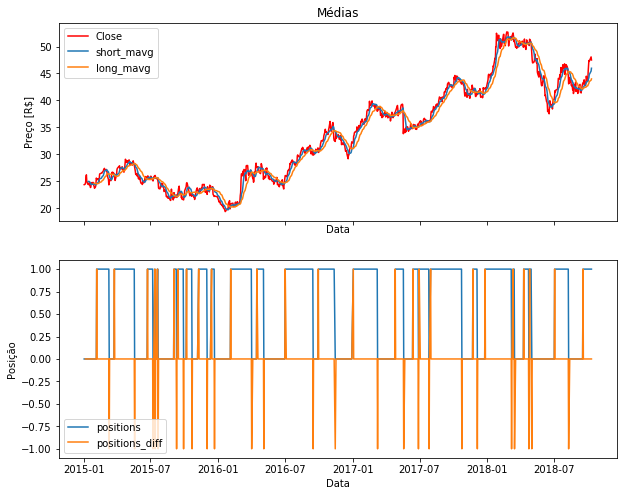

GOAU4.SA


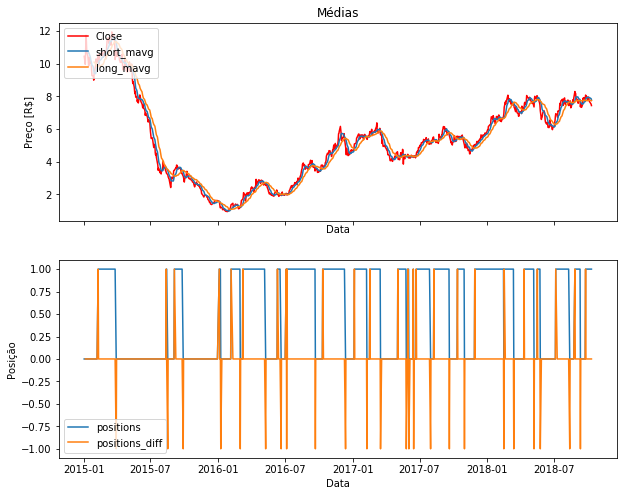

USIM5.SA


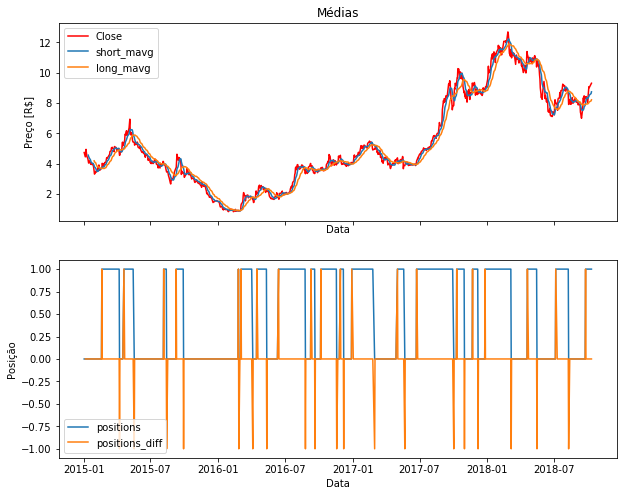

ITSA4.SA


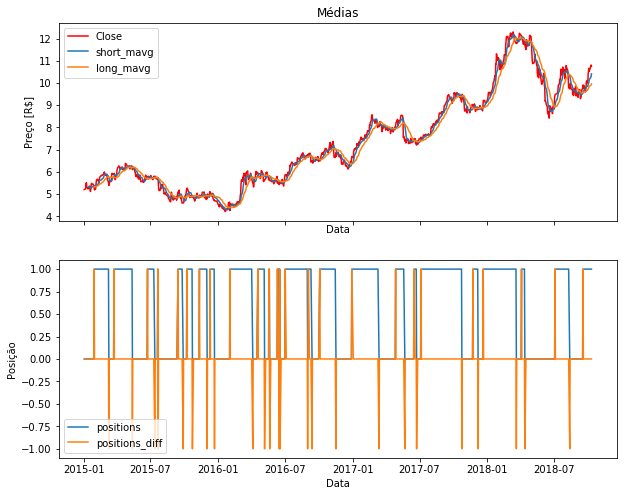

PETR4.SA


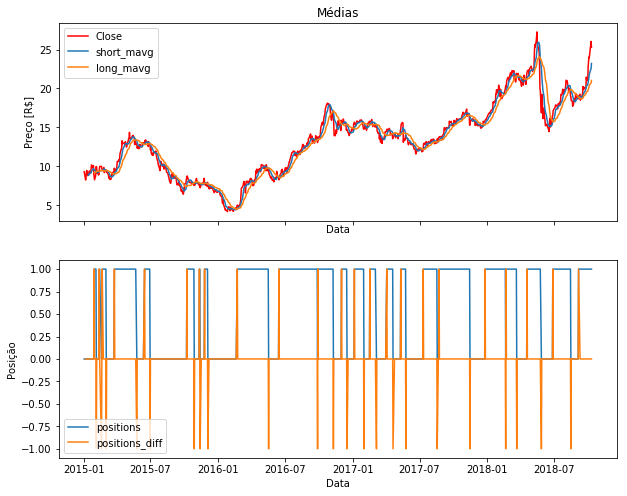

In [6]:
%matplotlib inline
for asset in top_5_keys:
    print(asset)
    signal = stock_data_adj_close[asset]
    
    plot_asset_mavg_position(signal)

### Plot das operações - 2

In [7]:
def plot_asset_mavg_buy_sell(asset):
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10,8))

    ax1.plot(asset['Adj Close'], lw=2.,label='Close')
    ax1.plot(asset[['short_mavg', 'long_mavg']])

    # Buy
    ax1.plot(asset.loc[asset.positions_diff >= 1.0].index, 
             asset.short_mavg[asset.positions_diff >= 1.0],
             '^', markersize=10, color='m',label='Buy')
    # Sell
    ax1.plot(asset.loc[asset.positions_diff <= -1.0].index, 
             asset.short_mavg[asset.positions_diff <= -1.0],
             'v', markersize=10, color='k',label='Sell')
    
    ax1.legend(loc='lower left')      
    ax1.set_ylabel("Preço [R$]")
    ax1.set_xlabel("Data")
    ax1.set_title("Médias")
    ax1.legend(loc='upper left')

    plt.show()

ITUB4.SA


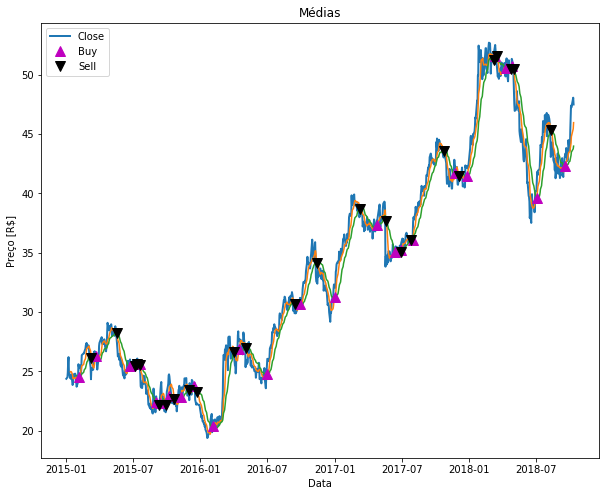

GOAU4.SA


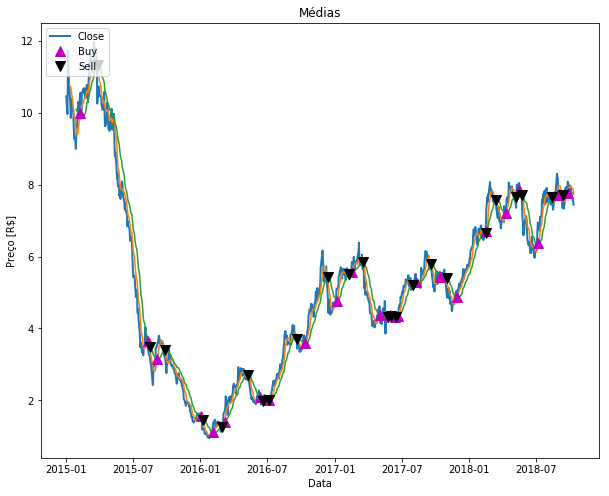

USIM5.SA


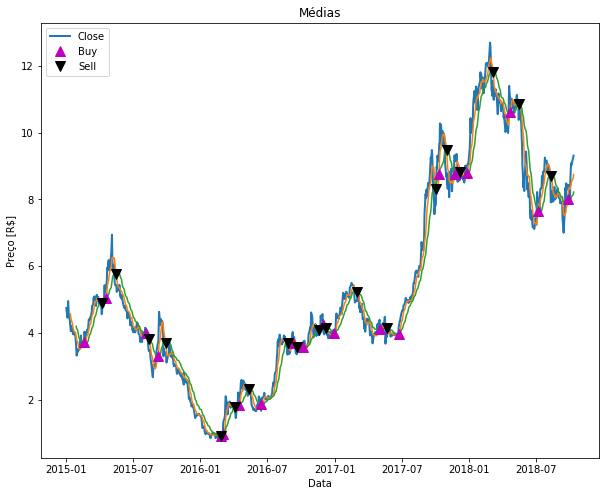

ITSA4.SA


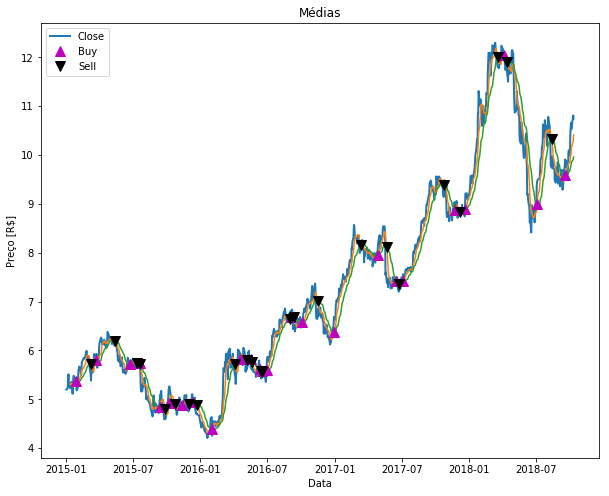

PETR4.SA


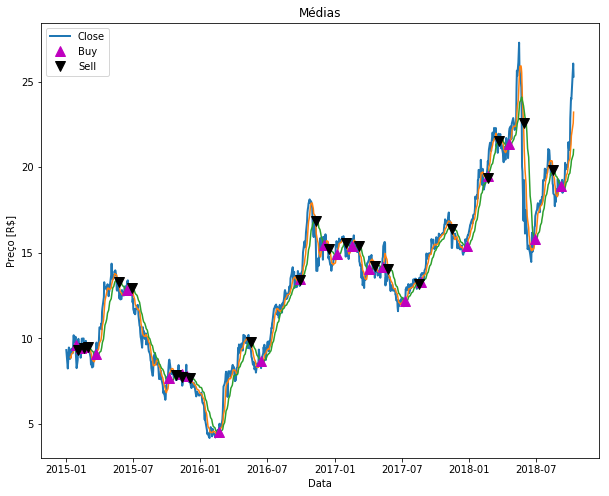

In [8]:
%matplotlib inline
for asset in top_5_keys:
    print(asset)
    signal = stock_data_adj_close[asset]
    
    plot_asset_mavg_buy_sell(signal)

### Funções para avaliar os Retornos

In [9]:
# Plot while operating, zero otherwise
def get_trading_positions(asset):
    positions = pd.DataFrame(index=asset.index).fillna(0.0)
    positions['Adj Close'] = asset['Adj Close']
    positions['trading_positions'] = asset['positions']

    positions['trading_positions'] = positions['Adj Close'].multiply(positions['trading_positions'], axis=0)
    positions.drop(columns=['Adj Close'], inplace=True)

    return positions

# # Get intervals while operating
def get_positon_itervals(price_df):
 
    bought = price_df[price_df['positions_diff'] >= 1].index
    sold = price_df[price_df['positions_diff'] <= -1].index
    
    
    sold = sold.insert(len(sold)+1,price_df.index[-1])
    bought = bought.insert(len(bought)+1,price_df.index[-1])

    #print('**************** bought: ', len(bought))
    #print('**************** sold: ', len(sold))
    if (abs(len(bought)-len(sold))>1):
        print('**************** dimension error ****************')
        
    
    if (bought[0] < sold[0]):
        if (len(bought) > len(sold)):
            positions_buy_and_sell = list(zip(bought[:-1],sold))
            positions_sell_and_buy = list(zip(sold[:-1],bought[1:-1]))
        else:
            positions_buy_and_sell = list(zip(bought[:-1],sold[:-1]))
            positions_sell_and_buy = list(zip(sold[:-1],bought[1:]))
            
    if (sold[0] < bought[0]):
        if (len(sold) > len(bought)):
            positions_buy_and_sell = list(zip(bought[:-1],sold[1:-1]))
            positions_sell_and_buy = list(zip(sold[:-1],bought))
        else:
            positions_buy_and_sell = list(zip(bought[:-1],sold[1:]))
            positions_sell_and_buy = list(zip(sold[:-1],bought[:-1]))
            
       
    positions = {'positions_buy_and_sell': positions_buy_and_sell, \
                 'positions_sell_and_buy': positions_sell_and_buy}
    
    return positions



def get_position_returns(price_df):
    BUY_POSITION = 1   # >1
    SELL_POSITION = -1 # <-1

    price_df['log_prices'] = np.log(price_df['Adj Close'])
    price_df['log_returns'] = 0.0
    positions_buy_sell = get_positon_itervals(price_df)
    
    for [start, end] in positions_buy_sell['positions_buy_and_sell']:
        if (start > end):
            a = end
            end = start
            start = a
        with pd.option_context('mode.chained_assignment', None):
            position = price_df[start:end]
            if position['positions'][0] >= 1:
                position['log_returns'] = position['log_prices'].diff().fillna(0)

    for [start, end] in positions_buy_sell['positions_sell_and_buy']:
        if (start > end):
            a = end
            end = start
            start = a
        with pd.option_context('mode.chained_assignment', None):
            position = price_df[start:end]
            if position['positions'][0] <= -1:
                position['log_returns'] = position['log_prices'].diff().fillna(0) * (-1)
            
            
    cumulative_log_return = price_df['log_returns'].cumsum()
    price_df['cumulative_returns'] = np.exp(cumulative_log_return) - 1 
    price_df['returns'] = np.exp(price_df['log_returns']) - 1 
    #price_df.drop(columns=['log_returns', 'log_prices'], inplace=True)
    
    return price_df

#a = get_position_returns(stock_data_adj_close['ITUB4.SA'])

### Retornos

ITUB4.SA


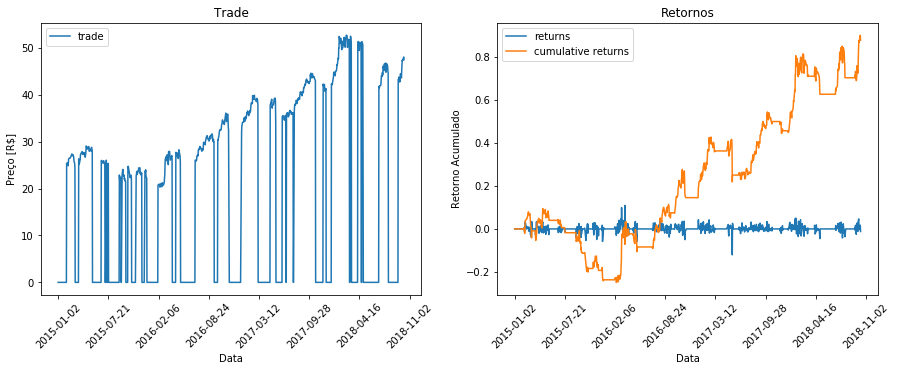

GOAU4.SA


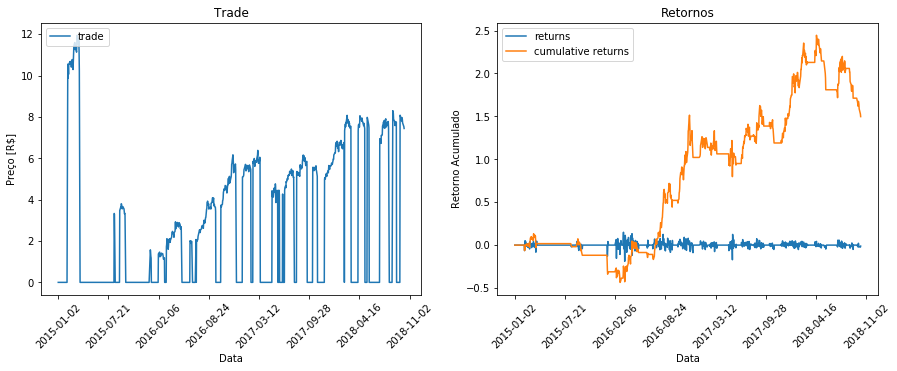

USIM5.SA


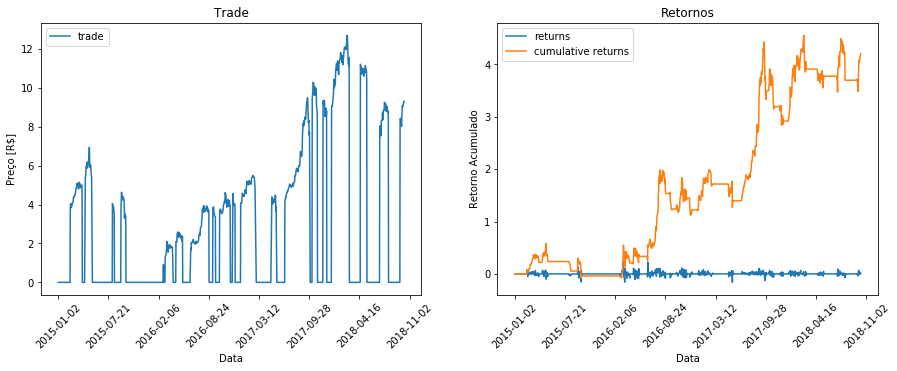

ITSA4.SA


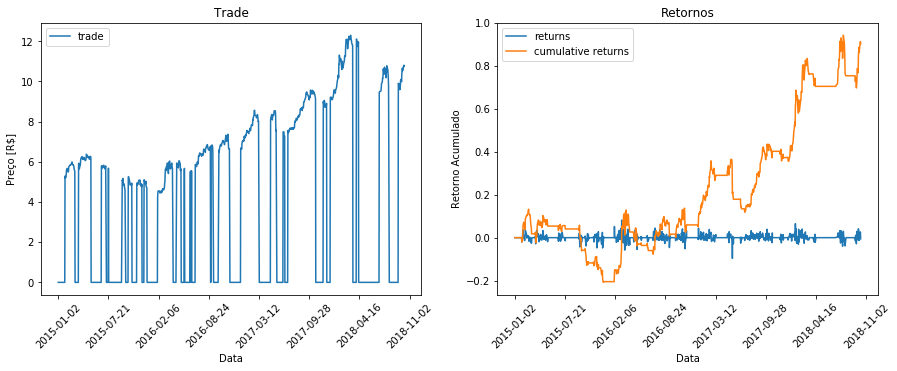

PETR4.SA


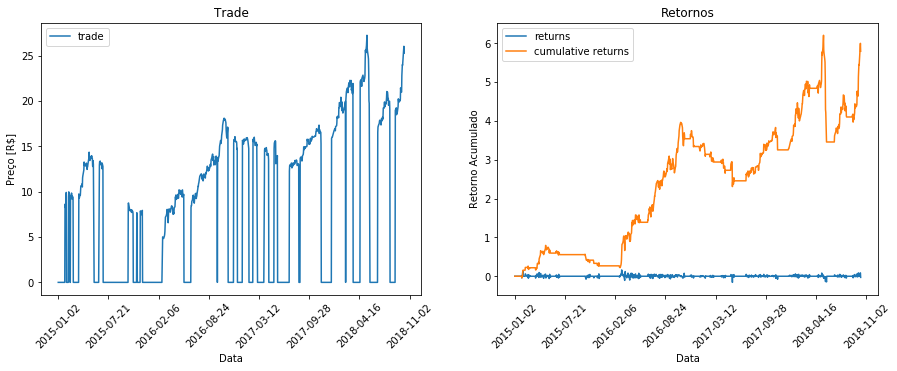

In [10]:
def plot_trade_returns(signal):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15,5))
    ax[0].plot(get_trading_positions(signal),label='trade')
    ax[0].legend(loc='upper left')
    for label in ax[0].xaxis.get_ticklabels():
        label.set_rotation(45)
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[0].xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax[0].set_ylabel("Preço [R$]")
    ax[0].set_xlabel("Data")
    ax[0].set_title("Trade")
    
    
    position_returns = get_position_returns(signal)
    ax[1].plot(position_returns['returns'],label='returns')
    ax[1].plot(position_returns['cumulative_returns'],label='cumulative returns')
    ax[1].legend(loc='upper left')
    for label in ax[1].xaxis.get_ticklabels():
        label.set_rotation(45)
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[1].xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax[1].set_ylabel("Retorno Acumulado")
    ax[1].set_xlabel("Data")
    ax[1].set_title("Retornos")
    
    plt.show()
    
%matplotlib inline
for asset in top_5_keys:
    print(asset)
    signal = stock_data_adj_close[asset]
    
    plot_trade_returns(signal)

### Indicadores

- O risk free rate sendo utilizado é de **0.05** anual.


- Para anualizar o desvio padrão:
\begin{align}
\sigma(annual) = \sigma(daily) * \sqrt(252)
\cr
\end{align}


- Para calcular o retorno anual:
\begin{align}
R(annual) = (R(daily) + 1)^{252/n} -1
\cr
R = \text{return}
\cr
n = \text{number of daily returns}
\end{align}

OU

\begin{align}
e^{(\overline{Rl}*252)} -1
\cr
\overline{Rl} = \text{mean of log returns}
\end{align}


In [11]:
def risk_adjusted_return_indicators(asset):
    position_returns = get_position_returns(asset)
    total_return = position_returns['cumulative_returns'][-1]
    print('total return: ', total_return)
    print('total days: ', len(position_returns)) 

    #display(position_returns.tail())
    anualized_return = (total_return + 1) ** (252/len(position_returns)) - 1
    #anualized_return = (np.exp(position_returns['log_returns'].mean() * 252) - 1)
    #WRONG->#anualized_return = position_returns['returns'].mean() * 252
    
    print('* anualized return: ', anualized_return)
    
    daily_std = position_returns['returns'].std()
    anual_std = daily_std * ((252)**(1/2))
    print('* anualized std: ', anual_std)
    
    risk_free = 0.05
    print('* risk free return: ', risk_free)
    print('------------------')
    sharpe_index = (anualized_return - risk_free) / anual_std
    print('SHARPE INDEX:', sharpe_index)
    print('******************\n')    
    
    indicators = {'sharpe_index': sharpe_index}
    return indicators

%matplotlib inline
for asset in top_5_keys:
    print(asset)
    signal = stock_data_adj_close[asset]
    #display_full(signal)
    risk_adjusted_return_indicators(signal)
    #break


ITUB4.SA
total return:  0.8769610160635226
total days:  942
* anualized return:  0.18346013824309293
* anualized std:  0.22809848382541287
* risk free return:  0.05
------------------
SHARPE INDEX: 0.5850987521041291
******************

GOAU4.SA
total return:  1.4975714205499555
total days:  942
* anualized return:  0.2774454755742679
* anualized std:  0.43955088815064436
* risk free return:  0.05
------------------
SHARPE INDEX: 0.5174497008326304
******************

USIM5.SA
total return:  4.2047740698968585
total days:  942
* anualized return:  0.5547082788221238
* anualized std:  0.47828299387581663
* risk free return:  0.05
------------------
SHARPE INDEX: 1.055250312648934
******************

ITSA4.SA
total return:  0.9018049728941722
total days:  942
* anualized return:  0.18763050617958443
* anualized std:  0.21838167883836868
* risk free return:  0.05
------------------
SHARPE INDEX: 0.6302291790761863
******************

PETR4.SA
total return:  5.793529676358909
total days:  

### Operando de outra forma: sempre que vender também comprar

ITUB4.SA
total return:  0.8913114623353502
total days:  942
* anualized return:  0.18587393664881802
* anualized std:  0.3020466418746594
* risk free return:  0.05
------------------
SHARPE INDEX: 0.4498442220893877
******************



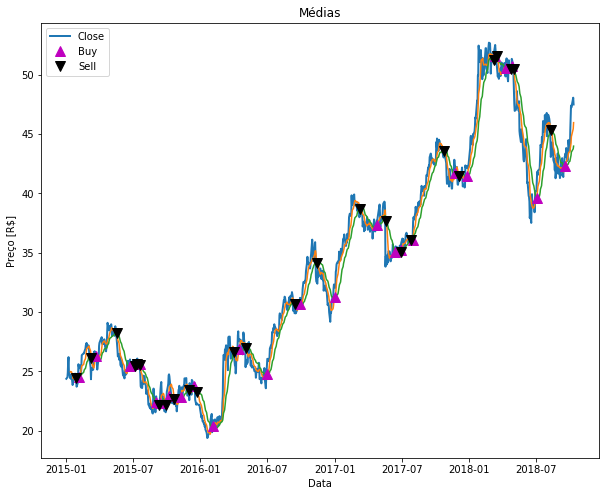

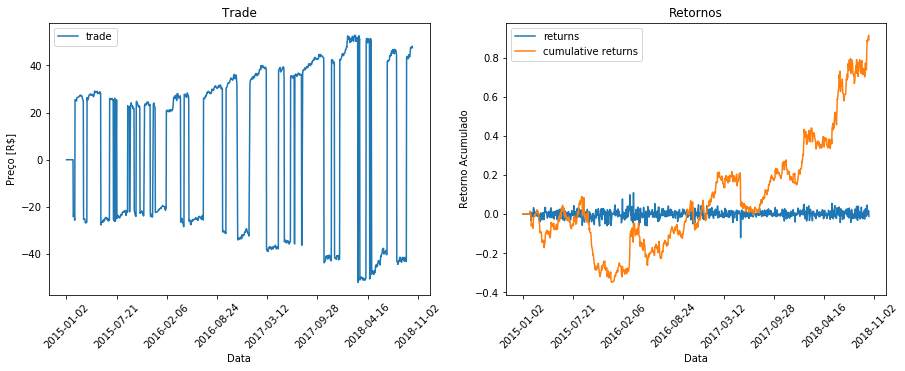

GOAU4.SA
total return:  8.756957638672931
total days:  942
* anualized return:  0.8393202854688488
* anualized std:  0.5907649122898607
* risk free return:  0.05
------------------
SHARPE INDEX: 1.3360987916654845
******************



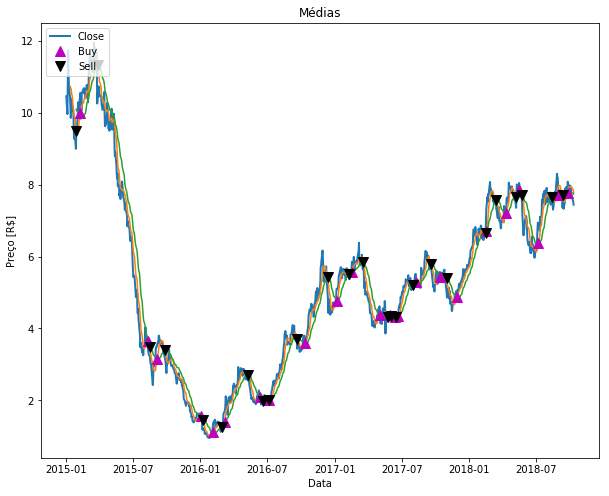

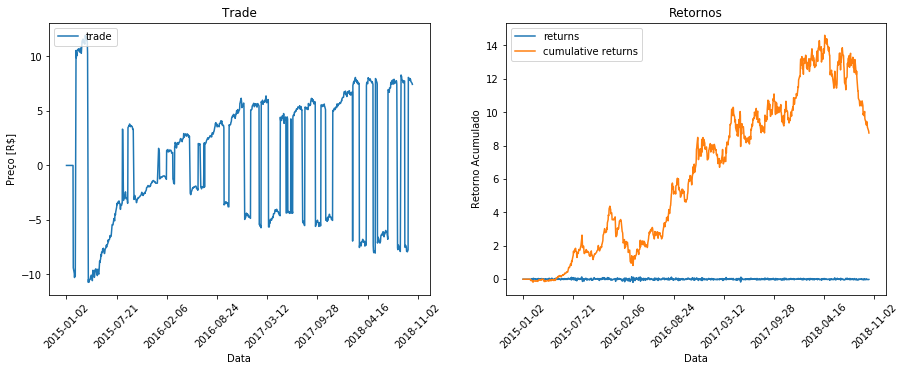

USIM5.SA
total return:  11.477596089356766
total days:  942
* anualized return:  0.9644115376514373
* anualized std:  0.6657861837931395
* risk free return:  0.05
------------------
SHARPE INDEX: 1.3734312304917788
******************



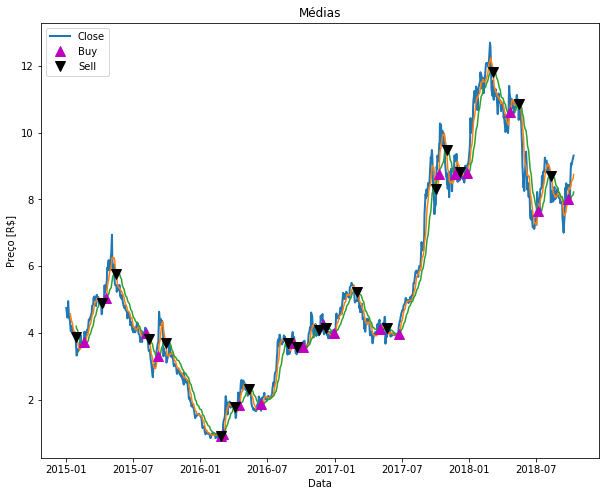

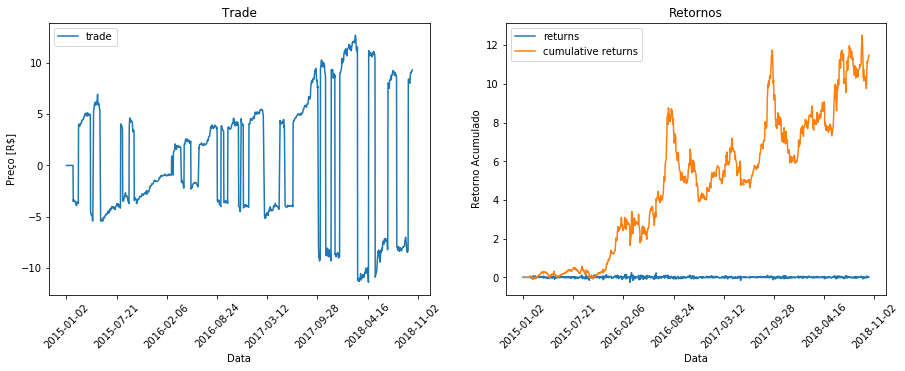

ITSA4.SA
total return:  1.0591334656345892
total days:  942
* anualized return:  0.213153059747496
* anualized std:  0.29623206292489607
* risk free return:  0.05
------------------
SHARPE INDEX: 0.5507609748133858
******************



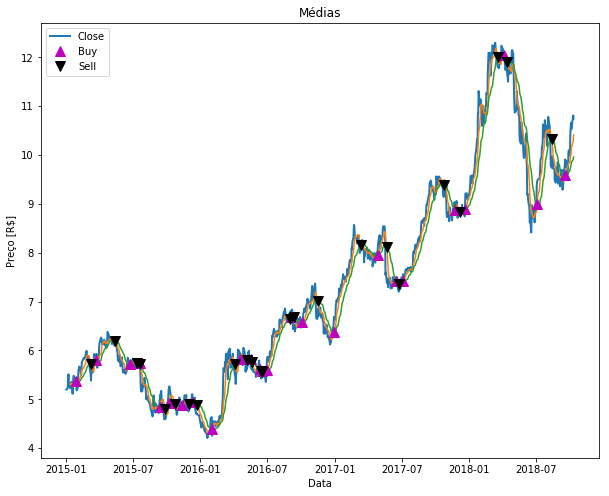

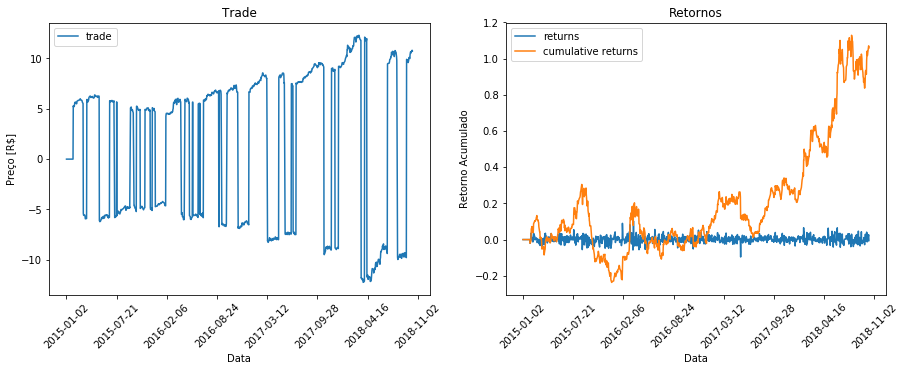

PETR4.SA
total return:  19.501816228729915
total days:  942
* anualized return:  1.2434962005873462
* anualized std:  0.520067789148071
* risk free return:  0.05
------------------
SHARPE INDEX: 2.2948858312152463
******************



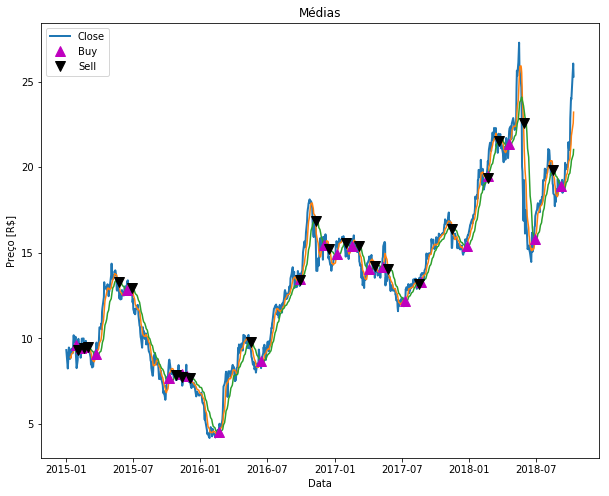

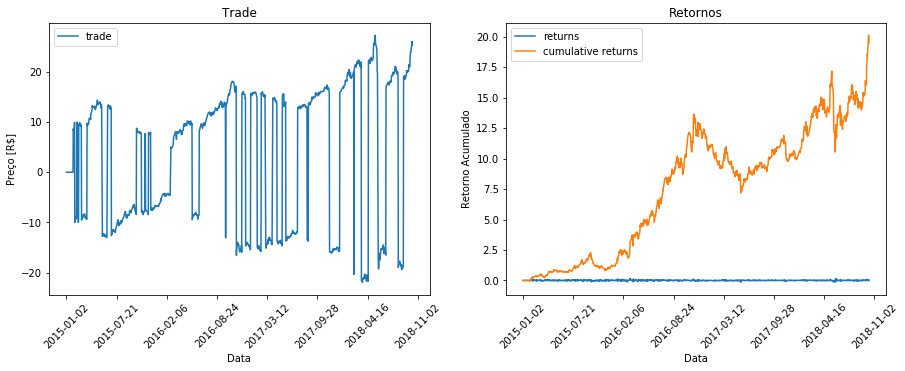

In [12]:
def short_and_long_mavg_2d_from_price_df(price_df, short_window, long_window):
    price = price_df.copy()
    
    # MOVING AVERAGE
    fast_ma = price.rolling(short_window).mean()
    slow_ma = price.rolling(long_window).mean()
    price['short_mavg'] = fast_ma
    price['long_mavg'] = slow_ma
    
    # BUY POSITION
    price['positions'] = 0.0
    price['positions'][short_window:] = np.where(price['short_mavg'][short_window:] \
                                            >= price['long_mavg'][short_window:], 1.0, 0.0)
    # SELL POSITION
    short_avg_bellow_long = price['short_mavg'][short_window:] < price['long_mavg'][short_window:]
    price['positions'][short_window:][short_avg_bellow_long] = -1.0

    price['positions_diff'] = price['positions'].diff().copy()
    
    return price

%matplotlib inline
for asset in top_5_keys:
    print(asset)
    price = stock_data[asset][['Adj Close']]
    mavg = short_and_long_mavg_2d_from_price_df(price, 8, 20)
    
    risk_adjusted_return_indicators(mavg)
    plot_asset_mavg_buy_sell(mavg)
    plot_trade_returns(mavg)


------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------

### Definindo estratégias 

Estratégias:
- Somente compra
- Compra e vende

In [13]:
def MACD_buy_only(price_df):
    stock = price_df.copy()
    
    stock['26 ema'] = stock['Adj Close'].ewm(span=26,adjust=False).mean() 
    stock['12 ema'] = stock['Adj Close'].ewm(span=12,adjust=False).mean()
    stock['MACD'] = (stock['12 ema'] - stock['26 ema'])
    stock['Signal Line'] = stock['MACD'].ewm(span=9,adjust=False).mean()
    stock['HisM'] = stock['MACD'] - stock['Signal Line']

    stock['positions'] = 0
    with pd.option_context('mode.chained_assignment', None):
        stock['positions'][stock['HisM'] >= 0] = 1

    stock['positions_diff'] = stock['positions'].diff().copy()
    stock = stock[26:]

    return stock

def MACD_buy_and_sell(price_df):
    stock = price_df.copy()
    
    stock['26 ema'] = stock['Adj Close'].ewm(span=26,adjust=False).mean() 
    stock['12 ema'] = stock['Adj Close'].ewm(span=12,adjust=False).mean()
    stock['MACD'] = (stock['12 ema'] - stock['26 ema'])
    stock['Signal Line'] = stock['MACD'].ewm(span=9,adjust=False).mean()
    stock['HisM'] = stock['MACD'] - stock['Signal Line']

    stock['positions'] = 0
    with pd.option_context('mode.chained_assignment', None):
        stock['positions'][stock['HisM'] >= 0] = 1
        stock['positions'][stock['HisM'] < 0] = -1

    stock['positions_diff'] = stock['positions'].diff().copy()
    stock = stock[26:]

    return stock

### Executando Estratégias:

************************ ITUB4.SA ************************
**********************************************************

****************************************************** ONLY BUY:
total return:  0.6032043533341684
total days:  916
* anualized return:  0.13866067400536397
* anualized std:  0.22264656482876968
* risk free return:  0.05
------------------
SHARPE INDEX: 0.3982126293911161
******************



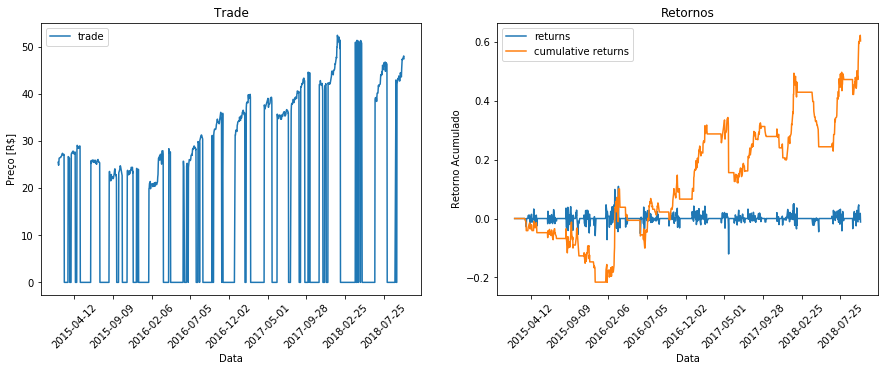

****************************************************** BUY AND SELL:
total return:  1.7854704690366585
total days:  916
* anualized return:  0.3255486547659845
* anualized std:  0.2935512198978313
* risk free return:  0.05
------------------
SHARPE INDEX: 0.9386731721363227
******************



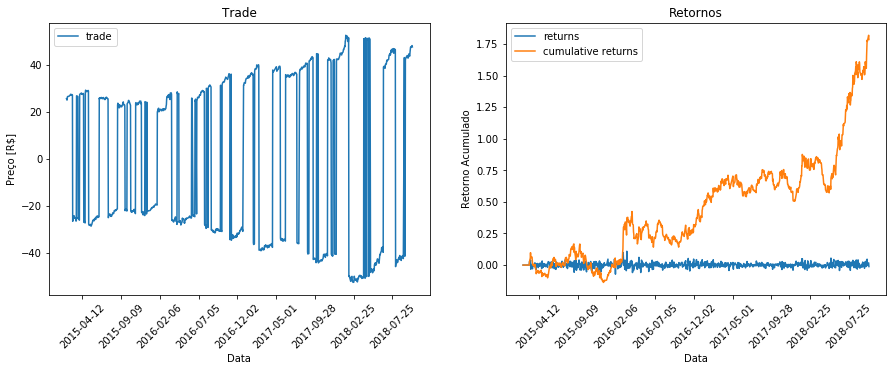

************************ GOAU4.SA ************************
**********************************************************

****************************************************** ONLY BUY:
total return:  1.6451064405873486
total days:  916
* anualized return:  0.3068266587113109
* anualized std:  0.46637805437697777
* risk free return:  0.05
------------------
SHARPE INDEX: 0.5506834129543229
******************



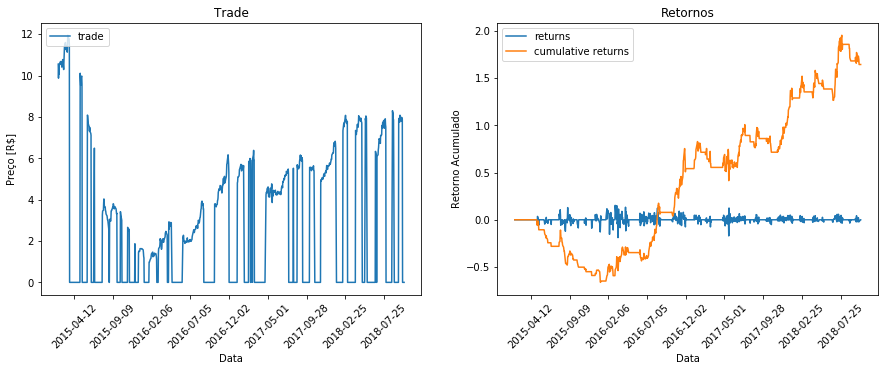

****************************************************** BUY AND SELL:
total return:  22.705132039911042
total days:  916
* anualized return:  1.3890857951913098
* anualized std:  0.5904405064986418
* risk free return:  0.05
------------------
SHARPE INDEX: 2.267943646231511
******************



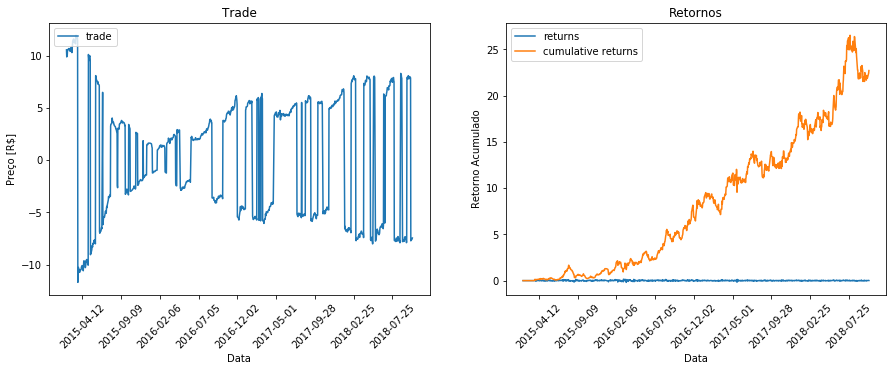

************************ USIM5.SA ************************
**********************************************************

****************************************************** ONLY BUY:
total return:  2.546703158540524
total days:  916
* anualized return:  0.41664768420670817
* anualized std:  0.5541572272670925
* risk free return:  0.05
------------------
SHARPE INDEX: 0.6616311511714553
******************



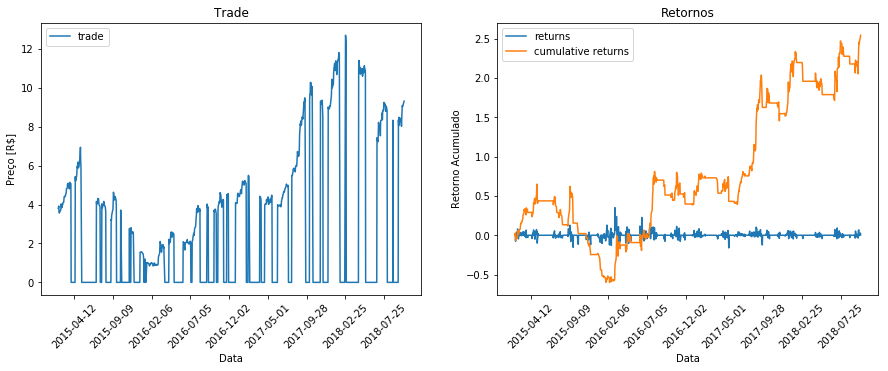

****************************************************** BUY AND SELL:
total return:  23.231589158399455
total days:  916
* anualized return:  1.4035665704108502
* anualized std:  0.6539607094005071
* risk free return:  0.05
------------------
SHARPE INDEX: 2.069798003081377
******************



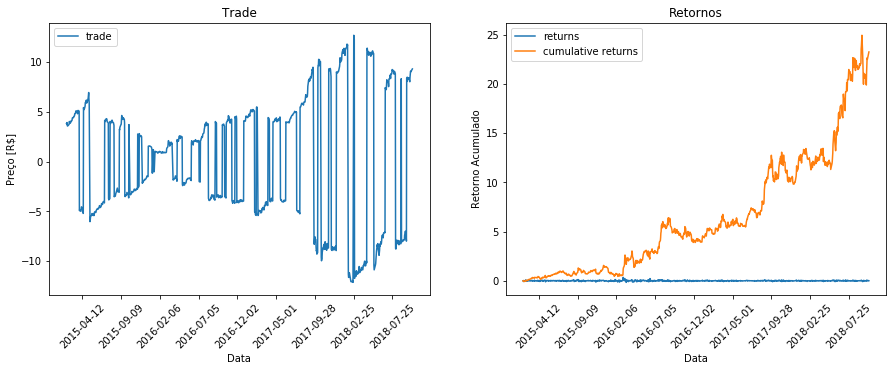

************************ ITSA4.SA ************************
**********************************************************

****************************************************** ONLY BUY:
total return:  0.9281309600668644
total days:  916
* anualized return:  0.19796374185752863
* anualized std:  0.2178397879202911
* risk free return:  0.05
------------------
SHARPE INDEX: 0.6792319404555676
******************



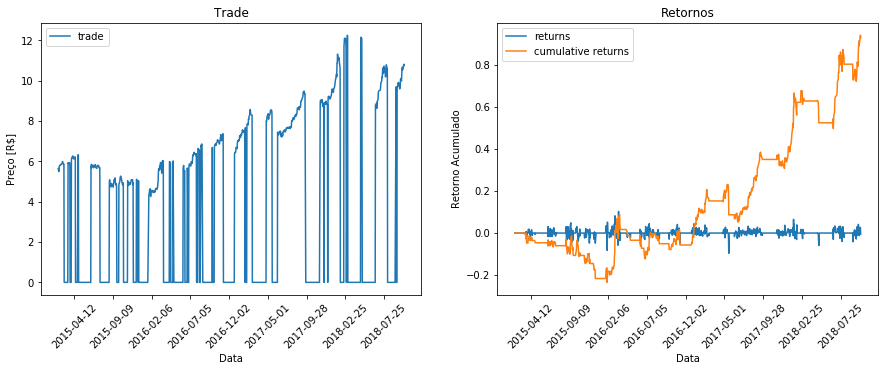

****************************************************** BUY AND SELL:
total return:  2.6432112171029862
total days:  916
* anualized return:  0.42714957915352714
* anualized std:  0.28587134596829483
* risk free return:  0.05
------------------
SHARPE INDEX: 1.3192982943990326
******************



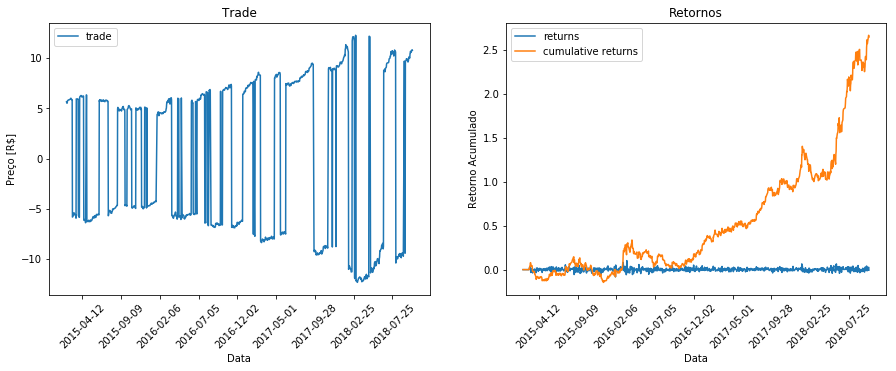

************************ PETR4.SA ************************
**********************************************************

****************************************************** ONLY BUY:
total return:  2.472188200981192
total days:  916
* anualized return:  0.40839642329877
* anualized std:  0.3689707460045435
* risk free return:  0.05
------------------
SHARPE INDEX: 0.9713410268421572
******************



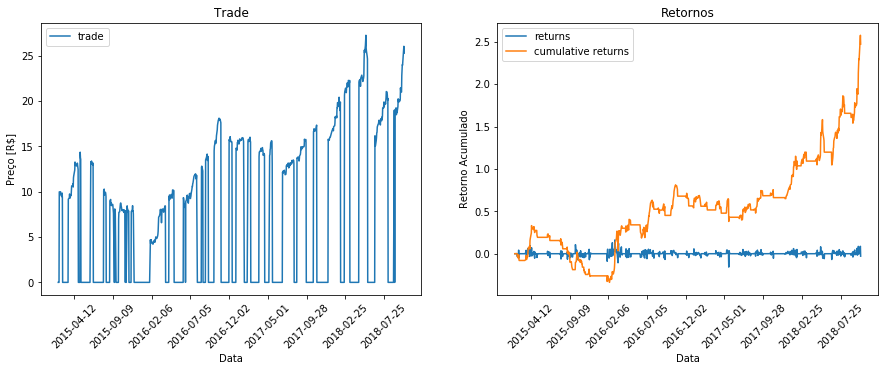

****************************************************** BUY AND SELL:
total return:  9.179776370103381
total days:  916
* anualized return:  0.8933810685683858
* anualized std:  0.5227704755461839
* risk free return:  0.05
------------------
SHARPE INDEX: 1.6132913162076186
******************



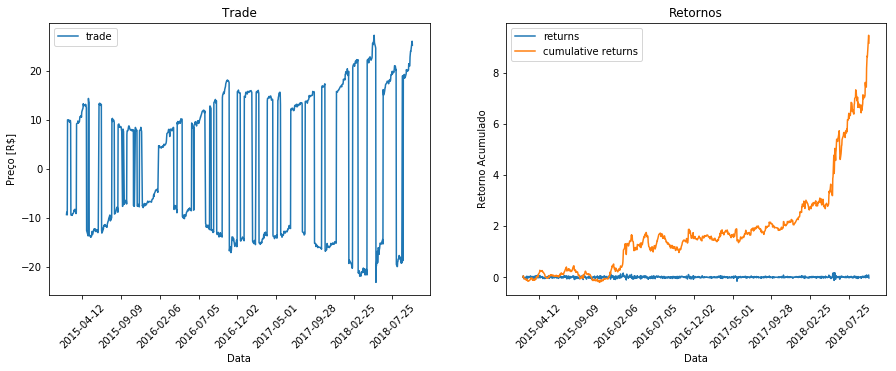

In [14]:
%matplotlib inline
for asset in top_5_keys:
    print('************************',asset,'************************')
    print('**********************************************************\n')
    price = stock_data[asset][['Adj Close']]
    #price.columns = ['Adj Close']

    macd_buy_only_df = MACD_buy_only(price)
    
    macd_buy_and_sell_df = MACD_buy_and_sell(price)
    
    print('****************************************************** ONLY BUY:')
    risk_adjusted_return_indicators(macd_buy_only_df)
    plot_trade_returns(macd_buy_only_df)

    
    print('****************************************************** BUY AND SELL:')
    risk_adjusted_return_indicators(macd_buy_and_sell_df)
    plot_trade_returns(macd_buy_and_sell_df)


### Definição da Estratégia:

Ainda é necessário otimizar os parâmetros dessa estratégia para **swing trade**. Ela não funcionou bem nesse contexto.


#### Estratégia Original

    - Média simples de 16 períodos
    - São estabelecidos dois limites equidistantes dessa média, um acima e um abaixo.
    - Ao ser atingido o limite inferior é colocada uma ordem de compra, e ao ser atingido o limite superior é colocada uma ordem de venda
    - Estas ordens de compra e venda são limitadas ou “na pedra”, e têm expiração de 15 minutos, indicando que serão canceladas se não forem executadas em até 15 minutos depois de colocadas.
    - 800 pontos como distância mínima à média
    - 50 pontos de deslocamento das ordens limitadas de entrada em relação ao preço
    - 400 pontos de target
    - 1000 pontos de stop

#### Estratégia Adaptada

    - Distância mínima à média: (0.07)*(preço da ação)
    - Target: (1/2) * Distância mínima à média
    - Stop: (1.25) * Distância mínima à média

In [15]:
def XEQUE_MATE(price_df):
    stock = price_df.copy()
    
    # MOVING AVERAGE
    mavg = price.rolling(16).mean()
    stock = stock[16:]
    stock['mavg'] = mavg
    stock['dif_from_avg'] = stock['Adj Close'] - stock['mavg']
    stock['price_percentage'] = stock['Adj Close']*0.07
    
    stock['place_order'] = 0
    place_sell_order = stock['dif_from_avg'] > stock['price_percentage']
    stock['place_order'][place_sell_order] = -1
    place_buy_order = (-1)*stock['dif_from_avg'] > stock['price_percentage']
    stock['place_order'][place_buy_order] = 1

    
    for i in range(0, len(stock)-1) :
#         Removing not placed orders
        if ((stock['place_order'].iloc[i] == 1) and (stock['place_order'].iloc[i+1] == 0)):
            stock['place_order'].iloc[i] = 0
        if ((stock['place_order'].iloc[i] == -1) and (stock['place_order'].iloc[i+1] == 0)):
            stock['place_order'].iloc[i] = 0

    i = 1
    while (i < len(stock)-2): 
        
        if ((stock['place_order'].iloc[i] == 1) ):
            action = 1
            initial_price = stock['Adj Close'].iloc[i]
            take_profit = stock['price_percentage'].iloc[i] * 0.5
            stop_loss = stock['price_percentage'].iloc[i] * 1.25
            
            for j in range(0,(10+1)):
                if (i + j) < len(stock)-1:
                    
                    # Take Profit
                    current_price = stock['Adj Close'].iloc[i+j]
                    if (current_price - initial_price > take_profit):
                        action = 0
                    # Stop Loss
                    if (current_price - initial_price < (-1)*stop_loss):
                        action = 0
                    
                    stock['place_order'].iloc[i+j] = action

            if (i + j + 1) < len(stock)-1:
                stock['place_order'].iloc[i+j+1] = 0
            i += j
            
        if ((stock['place_order'].iloc[i] == -1) ):
            action = -1
            initial_price = stock['Adj Close'].iloc[i]
            take_profit = stock['price_percentage'].iloc[i] * 0.5
            stop_loss = stock['price_percentage'].iloc[i] * 1.25
            
            for j in range(0,(10+1)):
                if (i + j) < len(stock)-1:
                    
                    # Take Profit
                    current_price = stock['Adj Close'].iloc[i+j]
                    if (initial_price - current_price > take_profit):
                        action = 0
                    # Stop Loss
                    if (initial_price - current_price < (-1)*stop_loss):
                        action = 0
                        
                    stock['place_order'].iloc[i+j] = action
                
            if (i + j + 1) < len(stock)-1:
                stock['place_order'].iloc[i+j+1] = 0   
            i += j
                
        i +=1
        
        
        stock['positions'] = stock['place_order']
        stock['positions_diff'] = stock['positions'].diff().copy()
        
        stock['positions'] = stock['positions'] + stock['positions_diff']
        
        
        stock = stock[1:]

 
    return stock
    

ITUB4.SA
******************



/Users/alexandretk/.venv/investment/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/alexandretk/.venv/investment/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/alexandretk/.venv/investment/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_index

total return:  0.4583191701458291
total days:  509
* anualized return:  0.20537315621842311
* anualized std:  0.2279888203657103
* risk free return:  0.05
------------------
SHARPE INDEX: 0.6814946275400413
******************



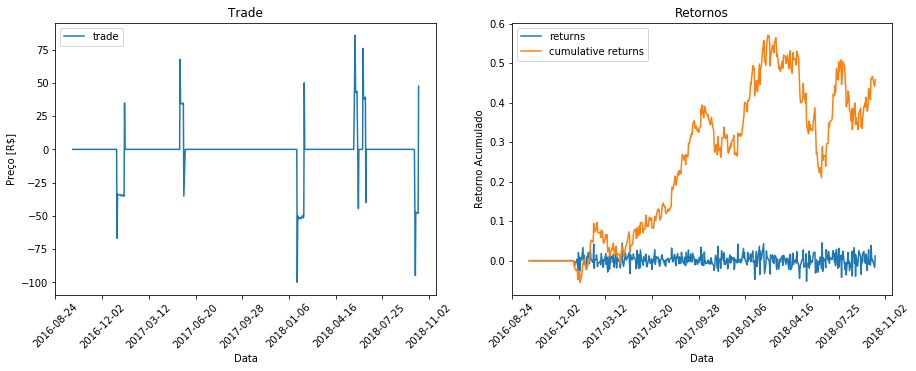

GOAU4.SA
******************

total return:  -0.8065118097445867
total days:  664
* anualized return:  -0.4638670776954975
* anualized std:  0.5398809339994634
* risk free return:  0.05
------------------
SHARPE INDEX: -0.9518155677192489
******************



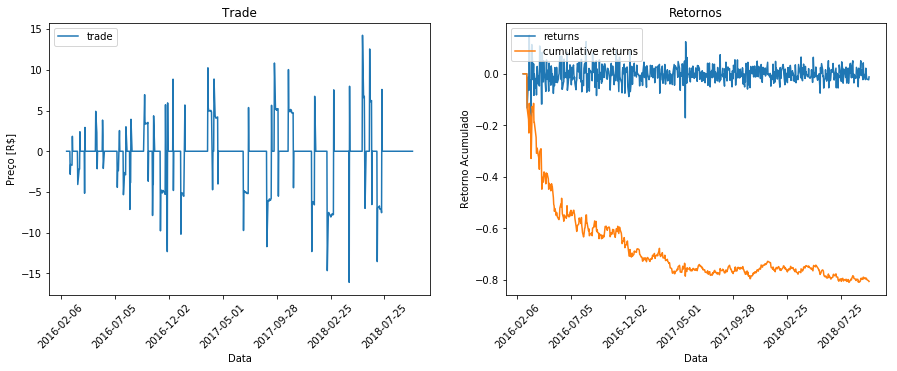

USIM5.SA
******************

total return:  -0.8413415355853907
total days:  699
* anualized return:  -0.4850619427290014
* anualized std:  0.6200998002646264
* risk free return:  0.05
------------------
SHARPE INDEX: -0.8628642397573177
******************



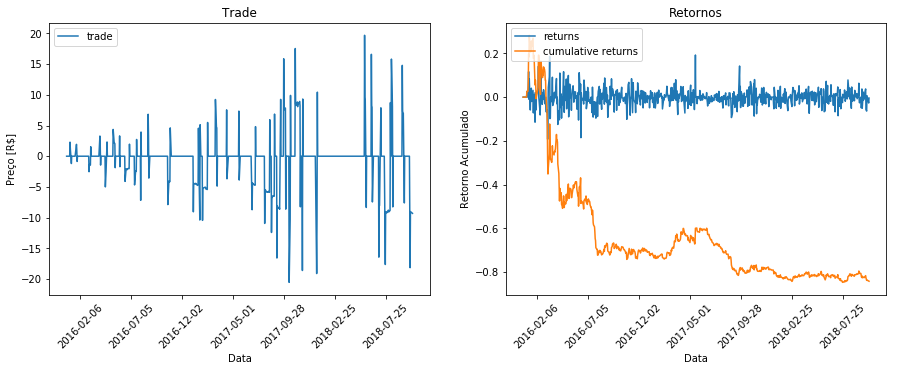

ITSA4.SA
******************

total return:  0.4312719919517689
total days:  509
* anualized return:  0.19425272998706866
* anualized std:  0.2359678703140617
* risk free return:  0.05
------------------
SHARPE INDEX: 0.6113236085704182
******************



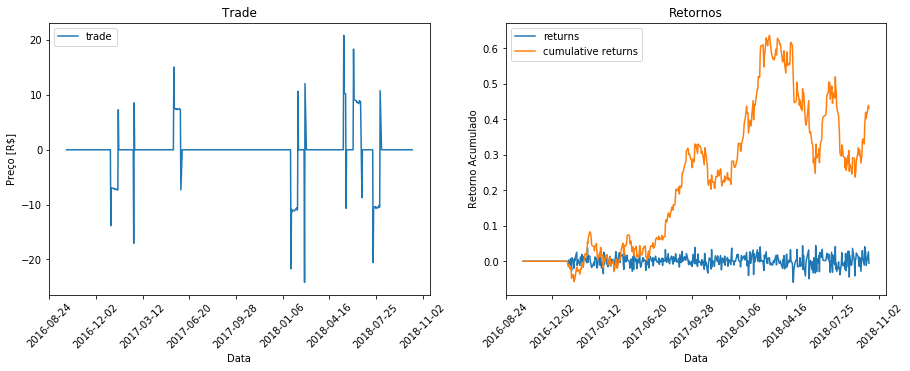

PETR4.SA
******************

total return:  2.3254380458989585
total days:  620
* anualized return:  0.6296949182372351
* anualized std:  0.43303837622930136
* risk free return:  0.05
------------------
SHARPE INDEX: 1.3386686955667793
******************



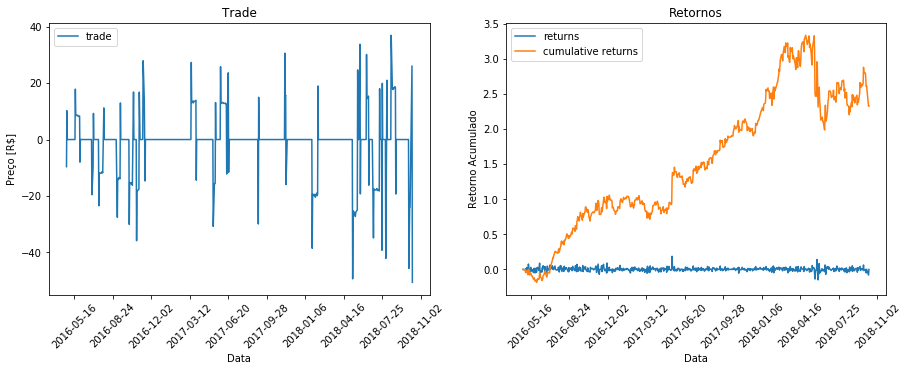

In [16]:
%matplotlib inline
for asset in top_5_keys:
    print(asset)
    print('******************\n')
    price = stock_data[asset][['Adj Close']]

    xeque_mate_df = XEQUE_MATE(price)

    risk_adjusted_return_indicators(xeque_mate_df)
    plot_trade_returns(xeque_mate_df)
    

### Definindo funções para calcular os indicadores

In [17]:
def get_position_returns_2(price_df):
    BUY_POSITION = 1   # >1
    SELL_POSITION = -1 # <-1
        
    # positions_diff -> START/STOP
    
    price_df['log_prices'] = np.log(price_df['Adj Close'])
    price_df['log_returns'] = 0.0
    positions_buy_sell = get_positon_itervals(price_df)
    
    gross_profit = 0
    gross_loss   = 0
    wins   = 0
    losses = 0 
    for [start, end] in positions_buy_sell['positions_buy_and_sell']:
        if (start > end):
            a = end
            end = start
            start = a
        with pd.option_context('mode.chained_assignment', None):
            position = price_df[start:end]
            if position['positions'][0] >= 1:
                position['log_returns'] = position['log_prices'].diff().fillna(0)
            
            price_change = position['Adj Close'][end] - position['Adj Close'][start]
            if(price_change > 0):
                gross_profit += price_change
                wins += 1
            else:
                gross_loss += (-1)*price_change
                losses += 1
                

            
    for [start, end] in positions_buy_sell['positions_sell_and_buy']:
        if (start > end):
            a = end
            end = start
            start = a
        with pd.option_context('mode.chained_assignment', None):
            position = price_df[start:end]
            if position['positions'][0] <= -1:
                position['log_returns'] = position['log_prices'].diff().fillna(0) * (-1)
            
            price_change = position['Adj Close'][end] - position['Adj Close'][start]
            if(price_change > 0):
                gross_profit += price_change
                wins += 1
            else:
                gross_loss += (-1)*price_change
                losses += 1
                
    cumulative_log_return = price_df['log_returns'].cumsum()
    price_df['cumulative_returns'] = np.exp(cumulative_log_return) - 1 
    price_df['returns'] = np.exp(price_df['log_returns']) - 1 
    #price_df.drop(columns=['log_returns', 'log_prices'], inplace=True)
    
    
    print('NUMERO DE TRADES: ',wins+losses)
    print('TAXA DE ACERTO: ', wins/(wins+losses))
    print('FATOR DE LUCRO: ', gross_profit/gross_loss)
    
    return price_df



def risk_adjusted_return_indicators_2(asset):
    position_returns = get_position_returns_2(asset)

    total_return = position_returns['cumulative_returns'][-1]

    anualized_return = (total_return + 1) ** (252/len(position_returns)) - 1
    print('ANUALIZED RETURN: ', anualized_return)
    
#     no_strategy_return = position_returns['Adj Close'][-1]/position_returns['Adj Close'][0] -1
#     anualized_no_strategy_return = (no_strategy_return + 1) ** (252/len(position_returns)) - 1
#     print('ANUALIZED RETURN WITHOUT STRATEGY: ', anualized_no_strategy_return)
    
    daily_std = position_returns['returns'].std()
    anual_std = daily_std * ((252)**(1/2))
 
    risk_free = 0.05
    sharpe_index = (anualized_return - risk_free) / anual_std
    print('ANUAL SHARPE INDEX:', sharpe_index)
  

    indicators = {'sharpe_index': sharpe_index}
    return indicators

### Resultados

In [18]:
%matplotlib inline
for asset in top_5_keys:
    print(asset)
    price = stock_data[asset][['Adj Close']]
    
    no_strategy_return = price['Adj Close'][-1]/price['Adj Close'][0] -1
    anualized_no_strategy_return = (no_strategy_return + 1) ** (252/len(price)) - 1
    print('ANUALIZED RETURN WITHOUT STRATEGY: ', anualized_no_strategy_return)
    print('\n')
    
    print('******** MAVG (BUY AND SELL) *********')
    mavg_buy_and_sell = short_and_long_mavg_2d_from_price_df(price, 8, 20)
    risk_adjusted_return_indicators_2(mavg_buy_and_sell)
    print('\n')
    
    print('******** MACD (BUY AND SELL) *********')
    print('BUY AND SELL:')
    macd_buy_and_sell_df = MACD_buy_and_sell(price)
    risk_adjusted_return_indicators_2(macd_buy_and_sell_df)
    print('\n')

    
    print('******** XEQUE MATE *********')
    print('BUY AND SELL:')
    xeque_mate_df = XEQUE_MATE(price)
    risk_adjusted_return_indicators_2(xeque_mate_df)
    print('\n')

ITUB4.SA
ANUALIZED RETURN WITHOUT STRATEGY:  0.1953313631403928


******** MAVG (BUY AND SELL) *********
NUMERO DE TRADES:  52
TAXA DE ACERTO:  0.5576923076923077
FATOR DE LUCRO:  1.6899595221352748
ANUALIZED RETURN:  0.18587393664881802
ANUAL SHARPE INDEX: 0.4498442220893877


******** MACD (BUY AND SELL) *********
BUY AND SELL:
NUMERO DE TRADES:  74
TAXA DE ACERTO:  0.5405405405405406
FATOR DE LUCRO:  1.3673834627980328
ANUALIZED RETURN:  0.3255486547659845
ANUAL SHARPE INDEX: 0.9386731721363227


******** XEQUE MATE *********
BUY AND SELL:


/Users/alexandretk/.venv/investment/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/alexandretk/.venv/investment/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/alexandretk/.venv/investment/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_index

NUMERO DE TRADES:  12
TAXA DE ACERTO:  0.6666666666666666
FATOR DE LUCRO:  3.9148259975053734
ANUALIZED RETURN:  0.20537315621842311
ANUAL SHARPE INDEX: 0.6814946275400413


GOAU4.SA
ANUALIZED RETURN WITHOUT STRATEGY:  -0.08695666995602847


******** MAVG (BUY AND SELL) *********
NUMERO DE TRADES:  50
TAXA DE ACERTO:  0.54
FATOR DE LUCRO:  0.8757669105225986
ANUALIZED RETURN:  0.8393202854688488
ANUAL SHARPE INDEX: 1.3360987916654845


******** MACD (BUY AND SELL) *********
BUY AND SELL:
NUMERO DE TRADES:  61
TAXA DE ACERTO:  0.45901639344262296
FATOR DE LUCRO:  0.7765508391095152
ANUALIZED RETURN:  1.3890857951913098
ANUAL SHARPE INDEX: 2.267943646231511


******** XEQUE MATE *********
BUY AND SELL:
NUMERO DE TRADES:  52
TAXA DE ACERTO:  0.6346153846153846
FATOR DE LUCRO:  1.5078765387666593
ANUALIZED RETURN:  -0.4638670776954975
ANUAL SHARPE INDEX: -0.9518155677192489


USIM5.SA
ANUALIZED RETURN WITHOUT STRATEGY:  0.19772992597630012


******** MAVG (BUY AND SELL) *********
NUMERO DE